# Using unlabelled, unfractionated datasets obtained from QExact and VOrbi instruments
* Datasets were searched against H_sapiens_Uniprot_SPROT_2017-04-12, Tryp_Pig_Bov sequence files using MSGFPlus
* Combined results with MASIC results (Q <= 0.01) to get quantitation data

In [35]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [36]:
import Classification_Utils as cu
import MaxQuant_Postprocessing_Functions as mq
import numpy as np
from os import listdir
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn import preprocessing
import time

## Load (and combine?) data from all tissues

In [37]:
HIGH_QUAL_DIR = 'F:\High_Quality\\'
MIXED_QUAL_DIR = 'F:\Mixed_Quality\\'
LOW_QUAL_DIR = 'F:\Low_Quality\\'
TEST_SET_DIR = 'F:\Test_Set\\'

files_dir = HIGH_QUAL_DIR

file_paths = listdir(files_dir) 

df = cu.combine_csvs(files_dir, file_paths)

In [38]:
df.dropna(axis='index', how='all', inplace=True) # drop any rows where all values are missing

original_df = df.copy()

print(df.shape)
df.head()

(119916, 89)


,Blood_Plasma_CPTAC_TrypDige_undepleted_normal_19Apr13_Methow_13-02-13,Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-10-25,Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW004_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW005_8Apr16_Arwen_16-01-03,Blood_Plasma_RZHJ_012_16Jun10_Owl_10-02-04,Blood_Plasma_Trypsin_Digestion_Step5_Sample1_4Mar13_Lynx_13-02-11,Blood_Plasma_Trypsin_Digestion_Step5_Sample2_4Mar13_Lynx_13-02-11,...,Temporal_Lobe_01,Temporal_Lobe_02,Temporal_Lobe_03,Temporal_Lobe_04,Temporal_Lobe_05,Temporal_Lobe_06,Temporal_Lobe_07,Temporal_Lobe_08,Temporal_Lobe_09,Temporal_Lobe_10
Peptide,,,,,,,,,,,,,,,,,,,,,
\n-.DIQM*TQSPSTLSASVGDR.V,111460000.0,4776900.0,NaN,6.740800e+08,1.013200e+09,NaN,201570000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.DIQM*TQSPSTLSASVGDRVTITCR.A,NaN,NaN,NaN,1.665500e+09,1.889800e+09,NaN,750580000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.DIQMTQSPS.T,113990000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.DIQMTQSPSTLSASVGDR.V,87789000.0,271390000.0,NaN,NaN,2.841000e+09,NaN,217430000.0,NaN,12897000.0,29051000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.DIQMTQSPSTLSASVGDRVTITCR.A,NaN,NaN,NaN,NaN,6.444900e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean data
* Log2 transform
* Impute missing values
* Mean/Median normalize

In [39]:
mq.log2_normalize(df)

df_min = df.min().min()
impute_val = df_min/2
df = df.fillna(impute_val)

# median normalize
mq.median_normalize(df)
#df.iloc[:,:] = preprocessing.RobustScaler().fit_transform(df)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:149: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,:] = np.log2(df.iloc[:,:])


## Map each column to a corresponding label

In [40]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)
#tissues_to_columns

In [41]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

# Sort columns by tissue type for visualization purposes

In [42]:
df.head()

,Blood_Plasma_CPTAC_TrypDige_undepleted_normal_19Apr13_Methow_13-02-13,Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-10-25,Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW004_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW005_8Apr16_Arwen_16-01-03,Blood_Plasma_RZHJ_012_16Jun10_Owl_10-02-04,Blood_Plasma_Trypsin_Digestion_Step5_Sample1_4Mar13_Lynx_13-02-11,Blood_Plasma_Trypsin_Digestion_Step5_Sample2_4Mar13_Lynx_13-02-11,...,Temporal_Lobe_01,Temporal_Lobe_02,Temporal_Lobe_03,Temporal_Lobe_04,Temporal_Lobe_05,Temporal_Lobe_06,Temporal_Lobe_07,Temporal_Lobe_08,Temporal_Lobe_09,Temporal_Lobe_10
Peptide,,,,,,,,,,,,,,,,,,,,,
\n-.DIQM*TQSPSTLSASVGDR.V,26.731951,22.187643,3.022208,29.328345,29.916272,3.022208,27.586706,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
\n-.DIQM*TQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,30.633308,30.815586,3.022208,29.483431,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
\n-.DIQMTQSPS.T,26.764332,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
\n-.DIQMTQSPSTLSASVGDR.V,26.387537,28.015792,3.022208,3.022208,31.403752,3.022208,27.695976,3.022208,23.620532,24.792084,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
\n-.DIQMTQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,3.022208,32.585511,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208


### Optional step to transform data

In [43]:
### Function to wrap whatever additional transformation is done to the train set, so that it can later be applied to the test set
def reduce_features(df):
    df = cu.keep_percentile_features(df, labels, 10)
    #df = cu.pairwise_transform(df)
    return df
    

In [44]:

transform_start_time = time.time()

df = reduce_features(df) 

print("--- %s minutes ---" % ((time.time() - transform_start_time)/60))
print(df.shape)

--- 0.006316665808359782 minutes ---
(11992, 89)


### For testing purposes: threshold data

In [11]:
import math

df_t = df.T
num_rows = df_t.shape[1]

one_protein_df = df_t.drop(df_t.columns[list(range(num_rows-1))], axis=1)
fifteen_protein_df = df_t.drop(df_t.columns[list(range(num_rows-15))], axis=1)
sixteenthpercent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(1599/1600))))], axis=1)
eighthpercent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(799/800))))], axis=1)
quarterpercent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(399/400))))], axis=1)
halfpercent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(199/200))))], axis=1)
one_percent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(99/100))))], axis=1)
twentieth_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(95/100))))], axis=1)
tenth_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(9/10))))], axis=1)
quarter_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(3/4))))], axis=1)
half_df = df_t.drop(df_t.columns[list(range(num_rows//2))], axis=1)
three_quarters_df = df_t.drop(df_t.columns[list(range(num_rows//4))], axis=1)
nine_tenths_df = df_t.drop(df_t.columns[list(range(num_rows//10))], axis=1)

In [12]:
thresholded_df = one_protein_df
thresholded_df.shape

(89, 1)

## Visualize data
* Normalized boxplots
* Scree plot
* PCA plot
* Pearson Matrix

In [23]:
image_dir = r'D:\Images\Human_Tissues\\'

column_to_color = mq.map_colors(tissues, tissues_to_columns, 9)

In [187]:
mq.make_seaborn_boxplot(df, image_dir, 'Median_normalized_boxplots', column_to_color)

In [24]:
#scaled_data = preprocessing.scale(df.T)
scaled_data = df.T

pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe

per_var, pca_labels = mq.make_scree_plot(pca, image_dir)
mq.draw_pca_graph2(column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, tissues, tissues_to_columns, 'PCA Plot')
#mq.draw_pca_graph(column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, 'PCA_RobustScaler_Annotated')

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [ ]:
mq.make_pearson_matrix(df, image_dir)

## Test various classifiers using cross-validation

In [43]:
NUM_FOLDS = 6
transformed_df = df.T
#transformed_df = thresholded_df

### Decision Tree

In [44]:
dt = cu.decisiontree_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.    0.94  1.    0.94  1.    1.  ]
accuracy: 0.98 (+/- 0.05)


### KNN

In [45]:
knn = cu.knn_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.    0.94  1.    0.94  0.89  1.  ]
accuracy: 0.96 (+/- 0.08)


### Logistic Regression

In [46]:
lr = cu.logistic_regression_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.  1.  1.  1.  1.  1.]
accuracy: 1.00 (+/- 0.00)


### Naive Bayes
* Gaussian
* Multinomial

In [49]:
gnb = cu.bayes_gaussian_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 0.72  0.94  0.78  0.82  0.89  0.89]
accuracy: 0.84 (+/- 0.15)


In [50]:
mnb = cu.bayes_multinomial_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.    0.94  1.    0.94  1.    1.  ]
accuracy: 0.98 (+/- 0.05)


### SVC variations

In [51]:
svc_models = cu.SVC_models_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.  1.  1.  1.  1.  1.]
accuracy: 1.00 (+/- 0.00)
Scores: [ 1.  1.  1.  1.  1.  1.]
accuracy: 1.00 (+/- 0.00)
Scores: [ 0.17  0.17  0.22  0.18  0.33  0.22]
accuracy: 0.21 (+/- 0.12)
Scores: [ 1.    0.94  1.    0.94  1.    1.  ]
accuracy: 0.98 (+/- 0.05)


### Aggregations
* Random Forest
* Gradient Boosting

In [52]:
rf = cu.randomforest_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.  1.  1.  1.  1.  1.]
accuracy: 1.00 (+/- 0.00)


In [53]:
gbc = cu.gradient_boosting_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.    1.    1.    0.94  1.    1.  ]
accuracy: 0.99 (+/- 0.04)


## Tune parameters of best models 
* Check accuracy score and F1 score (measure of precision and recall)

In [45]:
start_time = time.time()

### Gradient Boosting grid search

In [46]:
gbc_grid = cu.gbc_grid_search(NUM_FOLDS, 2)

gbc_grid.fit(transformed_df, labels)

print('Best Gradient Boosting parameters:\n', gbc_grid.best_params_)
print('\nBest Cross-Validation score:\n', gbc_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

Best Gradient Boosting parameters:
 {'classify__max_depth': 5, 'classify__min_samples_split': 3, 'classify__n_estimators': 25, 'reduce_dim': SelectPercentile(percentile=5,
         score_func=<function f_classif at 0x000000000C379048>), 'reduce_dim__percentile': 5}

Best Cross-Validation score:
 0.977528089888
--- 1159.721113272508 minutes ---


### Random Forest grid search

In [27]:
rf_grid = cu.rf_grid_search(NUM_FOLDS, 2)

rf_grid.fit(transformed_df, labels)

print('Best Random Forest parameters:\n', rf_grid.best_params_)
print('\nBest Cross-Validation score:\n', rf_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

KeyboardInterrupt: 

### SVC grid search

In [ ]:
svc_grid = cu.svc_grid_search(NUM_FOLDS, 2)

svc_grid.fit(transformed_df, labels)

print('Best SVC parameters:\n', svc_grid.best_params_)
print('\nBest Cross-Validation score:\n', svc_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

## PCA of data reduced according to best grid search reduction method

In [ ]:
from sklearn.feature_selection import SelectPercentile

percentile_75_df = SelectPercentile(percentile=75).fit_transform(transformed_df, labels)
percentile_75_df.shape

In [ ]:
pca_percentile = PCA() # create a PCA object
pca_percentile.fit(percentile_75_df) # do the math
pca_data_percentile = pca_percentile.transform(percentile_75_df) # get PCA coordinates for dataframe

per_var_percentile, pca_labels_percentile = mq.make_scree_plot(pca_percentile, image_dir, 'Scree_75_Percentile')
mq.draw_pca_graph2(column_names, pca_data_percentile, image_dir, column_to_color, per_var_percentile, pca_labels_percentile, tissues, tissues_to_columns, 'PCA_75_Percentile')

## Top expressed peptides per tissue

In [ ]:
cu.print_top_n_features(df, rf, 10)
cu.print_top_n_features_coef(df, lr, 10, tissues)

## Save model, test new data
* Save array/dataframe of features (via joblib) along with final model
* Write script to classify new data-- load features and fit new data on them

In [32]:
filename = r'Trained_Models\highqual_crossval_gbc.sav'
joblib.dump(gbc, open(filename, 'wb'))

### Load new data (test set)

In [59]:
TEST_SET_DIR = 'F:\Test_Set\\'

test_paths = listdir(TEST_SET_DIR) 

test_data = cu.combine_csvs(TEST_SET_DIR, test_paths)

### Generate test_labels. Columns in test set must start with [Tissue Name]
test_labels = []
for col in test_data.columns.values.tolist():
    for tissue in tissues:
        if col.startswith(tissue):
            test_labels.append(tissue)
            continue

test_data = reduce_features(test_df)

test_data = cu.fit_new_data(original_df, test_data)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

ValueError: Found input variables with inconsistent numbers of samples: [119916, 79]

In [9]:
test_data.head()

Peptide,-.DIQM*TQSPSTLSASVGDR.V,-.DIQM*TQSPSTLSASVGDRVTITCR.A,-.DIQMTQSPS.T,-.DIQMTQSPSTLSASVGDR.V,-.DIQMTQSPSTLSASVGDRVTITCR.A,-.EVQLVETGGGLIQPGGSLR.L,-.KVHGSLAR.A,-.LGEHNIDVLEGNEQFINAAR.I,-.LGEHNIDVLEGNEQFINAARI.I,-.LGEHNIDVLEGNEQFINAARII.T,...,Y.YTSVTPVLR.G,Y.YTTIQDLR.D,Y.YVAPEVLGPEKYDK.S,Y.YVSNEELR.G,Y.YVTIIDAPGHR.D,Y.YVYNIIGGLDEEGK.G,Y.YWGGQYTWDM*AK.H,Y.YWGGQYTWDMAK.H,Y.YYIQQDTK.G,Y.YYIQQDTKGDYQK.A
Blood_Plasma_OpPlasma_029_a_13Aug11_Jaguar_11-07-18,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
Blood_Plasma_OpPlasma_034_a_13Aug11_Jaguar_11-07-18,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
Blood_Plasma_OpPlasma_038_a_13Aug11_Jaguar_11-07-16,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
Blood_Plasma_OpPlasma_039_a_13Aug11_Jaguar_11-07-16,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
Blood_Plasma_OpPlasma_045_a_27Jul11_Jaguar_11-05-05,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,28.611752,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208


### Load model and predict new data

In [16]:
filename = r'Trained_Models\highqual_crossval_rf.sav'
# some time later...

# load the model from disk
loaded_model = joblib.load(open(filename, 'rb'))

In [17]:
pred = loaded_model.predict(test_data)
result = loaded_model.score(test_data, test_labels)

print(result)

0.569620253165


### Use models from notebook to predict new data

In [55]:
lr_pred = lr.predict(test_data)
lr_result = lr.score(test_data, test_labels)

mnb_pred = mnb.predict(test_data)
mnb_result = mnb.score(test_data, test_labels)

rf_pred = rf.predict(test_data)
rf_result = rf.score(test_data, test_labels)

svc_pred = svc_models[0].predict(test_data)
svc_result = svc_models[0].score(test_data, test_labels)

ValueError: X has 119916 features per sample; expecting 2500

In [36]:
print(svc_pred)
print(svc_result)

['Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Liver' 'Liver' 'Liver'
 'Liver' 'Liver' 'Liver' 'Liver' 'Liver' 'Liver' 'Liver' 'Blood_Plasma'
 'Monocyte' 'Monocyte' 'Monocyte' 'Monocyte' 'Blood_Plasma' 'Blood_Plasma'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Pancreas' 'Pancreas'
 'Blood_Plasma' 'Blood_Plasma' 'Blood_Plasma' 'Temporal_Lobe'
 'Temporal_Lobe' 'Temporal_Lobe' 'Temporal_Lobe' 'Temporal_Lobe'
 'Temporal_Lobe' 'Temporal_Lobe' 'Temporal_Lobe' 'Tempor

### Try with Pipeline

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

pipe = Pipeline([
        ('reduce_dim', PCA(n_components=8)),
        ('classify', SVC(kernel='linear'))])

pipe.fit(transformed_df, labels)
pipe_pred = pipe.predict(test_data)
pipe_result = pipe.score(test_data, test_labels)
print(pipe_result)

0.455696202532


##  Confusion matrices of best models' predictions on new data

Confusion matrix, without normalization
[[10  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0]
 [10  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  8  2]
 [ 0  0  0  0  0  0  0  0  6]]
Normalized confusion matrix
[[ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.   0.   0.   0.   0. ]
 [ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.4  0.   0.   0.   0.   0.   0.6  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.8  0.2]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1. ]]


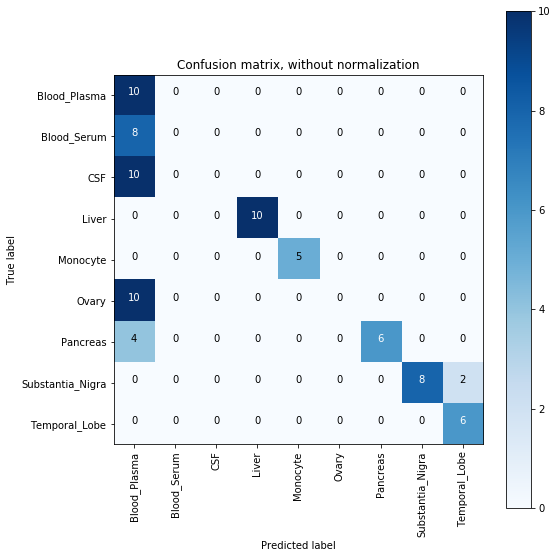

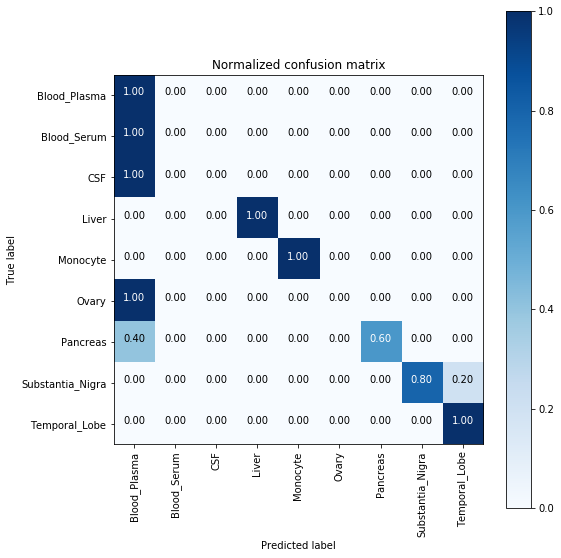

In [18]:
cu.show_confusion_matrices(test_labels, pred, tissues)
#cm_labels = list(set(lr_pred.tolist() + test_labels))

#cu.show_confusion_matrices(test_labels, mnb_pred, tissues)